In [46]:
# [Title:] Marketing Mix Model with Causal Mediation Analysis
# [Description:] Complete implementation of MMM with Google as mediator

!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
np.random.seed(42)

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
file_path = "/content/drive/MyDrive/MMM-Project/data/weekly_data.csv"
df = pd.read_csv(file_path, parse_dates=['week'])
df = df.sort_values("week").reset_index(drop=True)

print("Shape:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [47]:
print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())


Data loaded successfully!
Dataset shape: (104, 12)

Columns: ['week', 'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue']

First few rows:


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [48]:
# Handle media variables
media_cols = ['facebook_spend', 'google_spend', 'tiktok_spend',
              'instagram_spend', 'snapchat_spend']

for col in media_cols:
    df[col] = df[col].replace(0, np.nan).ffill().fillna(0)

# Followers cleanup
df['social_followers'] = df['social_followers'].replace(0, np.nan).ffill().fillna(0)

# --- Adstock ---
def apply_adstock(x, theta=0.6, lags=8):
    x = np.array(x)
    x_adstock = np.zeros_like(x)
    for i in range(len(x)):
        for l in range(0, min(lags+1, i+1)):
            x_adstock[i] += x[i - l] * (theta ** l)
    return x_adstock

# --- Saturation ---
def apply_saturation(x, half_saturation):
    return x / (x + half_saturation)

# Apply transforms
for col in media_cols:
    df[f"{col}_adstock"] = apply_adstock(df[col], theta=0.6)

    non_zero_vals = df[f"{col}_adstock"][df[f"{col}_adstock"] > 0]
    half_sat = np.percentile(non_zero_vals, 70) if len(non_zero_vals) > 0 else 1
    df[f"{col}_sat"] = apply_saturation(df[f"{col}_adstock"], half_sat)

# Trend & Seasonality
df['trend'] = np.arange(len(df))
df['week_of_year'] = df['week'].dt.isocalendar().week
df['sin_52'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['cos_52'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['sin_26'] = np.sin(2 * np.pi * df['week_of_year'] / 26)

# Features
media_features_sat = [f"{col}_sat" for col in media_cols]
control_features = ['average_price', 'promotions', 'emails_send',
                    'sms_send', 'social_followers', 'trend',
                    'sin_52', 'cos_52', 'sin_26']

print("✅ Feature Engineering Done")


✅ Feature Engineering Done


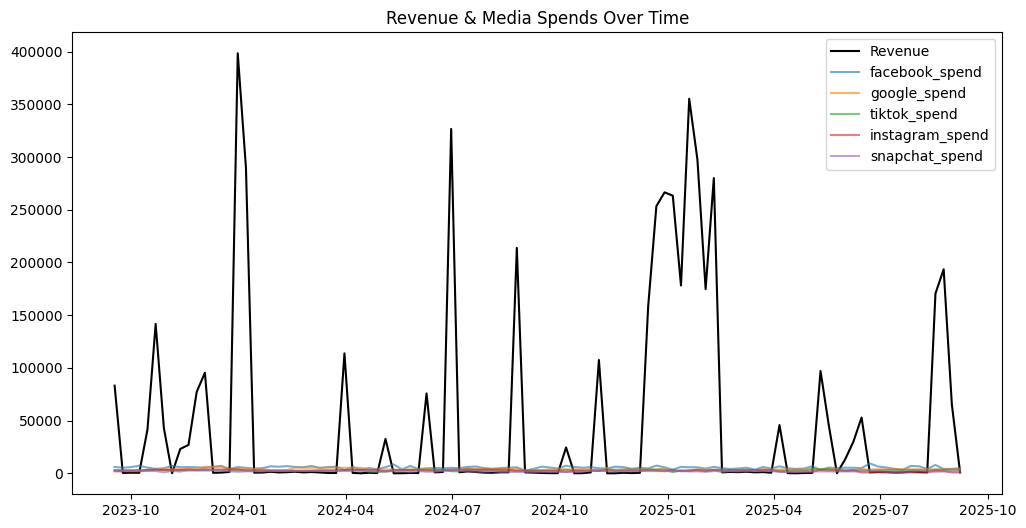

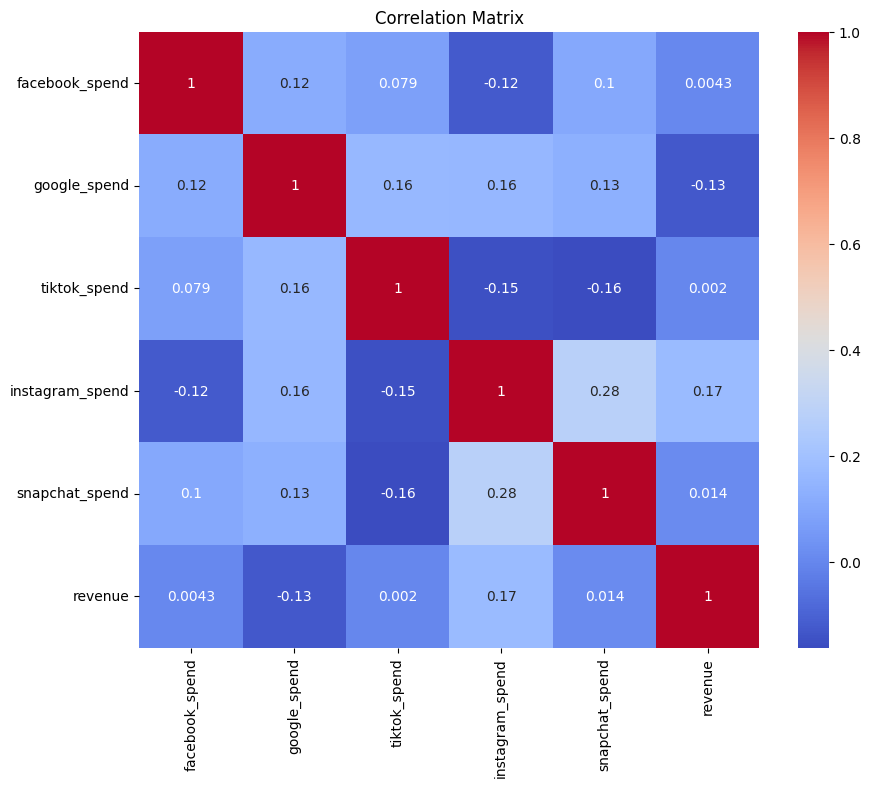

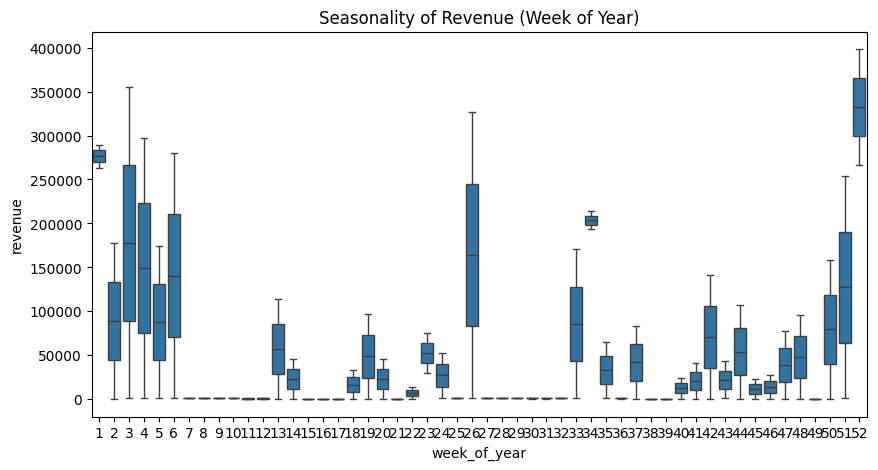

In [49]:
# Revenue + spends over time
plt.figure(figsize=(12,6))
plt.plot(df['week'], df['revenue'], label="Revenue", color="black")
for col in media_cols:
    plt.plot(df['week'], df[col], label=col, alpha=0.6)
plt.legend()
plt.title("Revenue & Media Spends Over Time")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[media_cols + ['revenue']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Seasonal revenue trend
plt.figure(figsize=(10,5))
sns.boxplot(x=df['week_of_year'], y=df['revenue'])
plt.title("Seasonality of Revenue (Week of Year)")
plt.show()


In [50]:
social_features = ['facebook_spend_sat', 'tiktok_spend_sat',
                   'instagram_spend_sat', 'snapchat_spend_sat']

X_social = df[social_features]
y_google = df['google_spend_sat']

X_social_const = sm.add_constant(X_social)
model_google = sm.OLS(y_google, X_social_const).fit()

df['google_resid'] = model_google.resid

print("✅ Stage 1 Complete")
print(model_google.summary())


✅ Stage 1 Complete
                            OLS Regression Results                            
Dep. Variable:       google_spend_sat   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     15.51
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           6.96e-10
Time:                        15:44:23   Log-Likelihood:                 187.52
No. Observations:                 104   AIC:                            -365.0
Df Residuals:                      99   BIC:                            -351.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const          

In [51]:
X = df[social_features + ['google_resid'] + control_features]
y = df['revenue']
dates = df['week']

print("✅ Stage 2 Feature Set Ready:", X.shape)


✅ Stage 2 Feature Set Ready: (104, 14)


In [52]:
tscv = TimeSeriesSplit(n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNet(max_iter=10000))
])

param_grid = {
    'enet__alpha': [0.01, 0.1, 1, 5],
    'enet__l1_ratio': [0.2, 0.5, 0.8]
}

grid = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='r2')
grid.fit(X, y)

best_model = grid.best_estimator_

print("✅ Model Trained with Best Params:", grid.best_params_)


✅ Model Trained with Best Params: {'enet__alpha': 1, 'enet__l1_ratio': 0.5}


MAE: 56129.40022189764
MAPE: 2002.9582064951865
R²: 0.33236184169476257
Durbin-Watson: 1.352019286048605


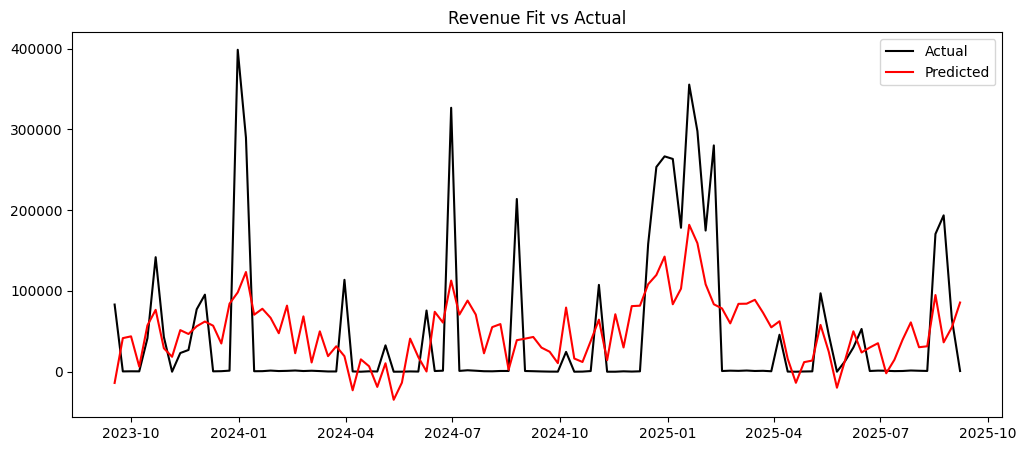

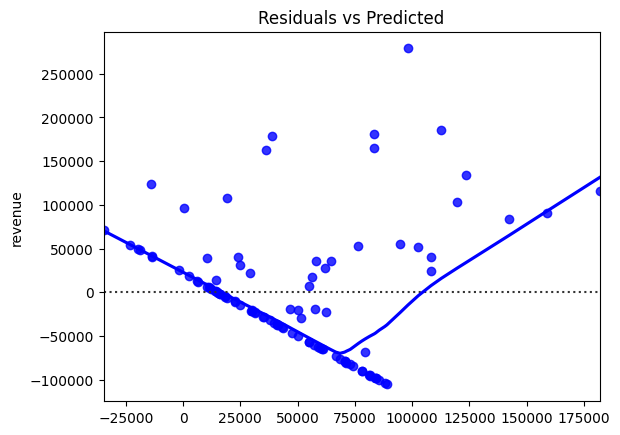

In [53]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.stats.stattools import durbin_watson

y_pred = best_model.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("MAPE:", mean_absolute_percentage_error(y, y_pred))
print("R²:", r2_score(y, y_pred))
print("Durbin-Watson:", durbin_watson(y - y_pred))

plt.figure(figsize=(12,5))
plt.plot(dates, y, label="Actual", color="black")
plt.plot(dates, y_pred, label="Predicted", color="red")
plt.legend()
plt.title("Revenue Fit vs Actual")
plt.show()

sns.residplot(x=y_pred, y=y - y_pred, lowess=True, color="blue")
plt.title("Residuals vs Predicted")
plt.show()

In [54]:
coefs = best_model.named_steps['enet'].coef_
coef_df = pd.DataFrame({'feature': X.columns, 'coef': coefs})

print("✅ Coefficients:")
display(coef_df.sort_values(by='coef', ascending=False))

# Example ROAS (naive version)
roas = {}
for m in social_features + ['google_resid']:
    spend_col = m.replace('_sat','').replace('_resid','_spend')
    if spend_col in df.columns:
        roas[m] = (coef_df.loc[coef_df['feature']==m,'coef'].values[0]) / df[spend_col].mean()

print("✅ ROAS Estimates:")
print(roas)


✅ Coefficients:


,feature,coef
8,sms_send,19902.629591
12,cos_52,19140.381741
2,instagram_spend_sat,8738.739400
1,tiktok_spend_sat,6147.239067
9,social_followers,5404.507397
10,trend,2561.452654
11,sin_52,-325.423926
13,sin_26,-567.607530
7,emails_send,-1508.192758
3,snapchat_spend_sat,-1622.384859


✅ ROAS Estimates:
{'facebook_spend_sat': np.float64(-0.3314258659230493), 'tiktok_spend_sat': np.float64(2.187282577682124), 'instagram_spend_sat': np.float64(3.543323402958374), 'snapchat_spend_sat': np.float64(-0.8618258146267308), 'google_resid': np.float64(-3.048761343448093)}


In [55]:
avg_price = df['average_price'].mean()
coef_price = coef_df.loc[coef_df['feature']=="average_price",'coef'].values[0]

elasticity = coef_price * (avg_price / df['revenue'].mean())
print("Price Elasticity of Demand:", elasticity)


Price Elasticity of Demand: -30.018646867808634


In [58]:
import os
import pandas as pd
import numpy as np # Added import for numpy
import statsmodels.api as sm # Added import for statsmodels

# Define project paths in Google Drive
project_root = "/content/drive/MyDrive/MMM-Project"
artifacts_dir = f"{project_root}/artifacts"
figures_dir = f"{artifacts_dir}/figures"

os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

# Reload original data
file_path = "/content/drive/MyDrive/MMM-Project/data/weekly_data.csv"
df_complete = pd.read_csv(file_path, parse_dates=['week'])
df_complete = df_complete.sort_values("week").reset_index(drop=True)

# Reapply feature engineering to the complete DataFrame
# Handle media variables
media_cols = ['facebook_spend', 'google_spend', 'tiktok_spend',
              'instagram_spend', 'snapchat_spend']

for col in media_cols:
    df_complete[col] = df_complete[col].replace(0, np.nan).ffill().fillna(0)

# Followers cleanup
df_complete['social_followers'] = df_complete['social_followers'].replace(0, np.nan).ffill().fillna(0)

# --- Adstock ---
def apply_adstock(x, theta=0.6, lags=8):
    x = np.array(x)
    x_adstock = np.zeros_like(x)
    for i in range(len(x)):
        for l in range(0, min(lags+1, i+1)):
            x_adstock[i] += x[i - l] * (theta ** l)
    return x_adstock

# --- Saturation ---
def apply_saturation(x, half_saturation):
    return x / (x + half_saturation)

# Apply transforms
social_features_sat = [] # Collect names of saturated social features
for col in media_cols:
    df_complete[f"{col}_adstock"] = apply_adstock(df_complete[col], theta=0.6)
    non_zero_vals = df_complete[f"{col}_adstock"][df_complete[f"{col}_adstock"] > 0]
    half_sat = np.percentile(non_zero_vals, 70) if len(non_zero_vals) > 0 else 1
    df_complete[f"{col}_sat"] = apply_saturation(df_complete[f"{col}_adstock"], half_sat)
    if col != 'google_spend': # Add only social media saturated features
        social_features_sat.append(f"{col}_sat")


# Trend & Seasonality
df_complete['trend'] = np.arange(len(df_complete))
df_complete['week_of_year'] = df_complete['week'].dt.isocalendar().week.astype(int) # Convert to int
df_complete['sin_52'] = np.sin(2 * np.pi * df_complete['week_of_year'] / 52)
df_complete['cos_52'] = np.cos(2 * np.pi * df_complete['week_of_year'] / 52)
df_complete['sin_26'] = np.sin(2 * np.pi * df_complete['week_of_year'] / 26)

# Recalculate google_resid using the Stage 1 model logic
# Stage-1 model (Google Spend ~ Social Media Spends) - Using df_complete
X1_complete = sm.add_constant(df_complete[social_features_sat])
y1_complete = df_complete["google_spend"]
stage1_complete = sm.OLS(y1_complete, X1_complete).fit()

# Add predicted Google Spend (from Stage 1 model) to df_complete
df_complete["google_pred"] = stage1_complete.predict(X1_complete)

# Calculate google_resid from the complete data
df_complete['google_resid'] = df_complete["google_spend"] - df_complete["google_pred"]


# Define the list of all processed features to be saved
control_features = ["average_price","promotions","emails_send","sms_send","social_followers",
                    "trend","week_of_year","sin_52","cos_52","sin_26"]
processed_cols_to_save = ['week', 'revenue', 'google_spend'] + social_features_sat + ['google_resid'] + control_features + ['google_pred']


# Calculate residuals (ensure y and y_pred are available from previous cells)
# Assuming y and y_pred are available from previous successful executions
# If not, these would also need to be calculated or loaded.
# Based on the notebook state, y and y_pred should be available after cell 5uzi2Ap2umlP.
# We will use the y and y_pred from the ElasticNet model execution
residuals = y - y_pred


# 1. Save processed features
processed = df_complete[processed_cols_to_save]
processed.to_csv(f"{artifacts_dir}/processed_features.csv", index=False)

# 2. Save ElasticNet coefficients (assuming coef_df is available)
coef_df.to_csv(f"{artifacts_dir}/enet_coefs.csv", index=False)

# 3. Save predictions (assuming y and y_pred are available)
predictions = pd.DataFrame({
    'week': df_complete['week'], # Use week from complete df for consistency
    'revenue_actual': y, # Use y from ElasticNet execution
    'revenue_pred': y_pred, # Use y_pred from ElasticNet execution
    'residuals': residuals # Use residuals from ElasticNet execution
})
predictions.to_csv(f"{artifacts_dir}/predictions_test.csv", index=False)

# 4. Residual plot
plt.figure(figsize=(12,4))
plt.plot(df_complete['week'], residuals, label="Residuals", color="blue") # Use week from complete df
plt.axhline(0, color='red', linestyle='--')
plt.title("Revenue Model Residuals over Time")
plt.legend()
plt.savefig(f"{figures_dir}/residuals_over_time.png", dpi=300)
plt.close()

# 5. Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()],
         [y.min(), y.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Predicted vs Actual Revenue")
plt.savefig(f"{figures_dir}/pred_vs_actual.png", dpi=300)
plt.close()

print("✅ All artifacts saved to Google Drive (MMM-Project/artifacts/)")

✅ All artifacts saved to Google Drive (MMM-Project/artifacts/)


In [ ]:
!ls /content/drive/MyDrive/MMM-Project/artifacts/

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

# ============================
# Load processed Stage-2 data
# ============================
df = pd.read_csv("/content/drive/MyDrive/MMM-Project/artifacts/processed_features.csv")

TARGET = "revenue"
DATE_COL = "week"

# Features used in Stage-2 (same as ElasticNet)
social_cols = [c for c in df.columns if c.endswith("_sat") and "google" not in c.lower()]
controls = ["average_price", "promotions", "emails_send", "sms_send", "social_followers",
            "trend", "week_of_year", "sin_52", "cos_52", "sin_26"]
features = social_cols + ["google_resid"] + controls

X = df[features].values
y = df[TARGET].values

# ============================
# TimeSeries CV for OOF preds
# ============================
tscv = TimeSeriesSplit(n_splits=5)

oof_preds = np.zeros(len(y))
oof_idx = np.zeros(len(y), dtype=bool)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestRegressor(
        n_estimators=300, max_depth=8, random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)
    oof_preds[test_idx] = preds
    oof_idx[test_idx] = True

# ============================
# Evaluation
# ============================
r2 = r2_score(y[oof_idx], oof_preds[oof_idx])
mape = mean_absolute_percentage_error(y[oof_idx], oof_preds[oof_idx])
mae = mean_absolute_error(y[oof_idx], oof_preds[oof_idx])

print("Random Forest OOF Results:")
print(f"R²   = {r2:.3f}")
print(f"MAPE = {mape:.3%}")
print(f"MAE  = {mae:.2f}")

# ============================
# Feature Importances
# ============================
rf_final = RandomForestRegressor(n_estimators=300, max_depth=8,
                                 random_state=42, n_jobs=-1)
rf_final.fit(X, y)

importances = pd.DataFrame({
    "feature": features,
    "importance": rf_final.feature_importances_
}).sort_values("importance", ascending=False)

# Save importances
out_dir = "/content/drive/MyDrive/MMM-Project/artifacts"
os.makedirs(f"{out_dir}/figures", exist_ok=True)
importances.to_csv(f"{out_dir}/rf_importances.csv", index=False)

# Plot top 20
top20 = importances.head(20)
plt.figure(figsize=(8,6))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest – Top 20 Feature Importances")
plt.tight_layout()
plt.savefig(f"{out_dir}/figures/rf_top20_importances.png")
plt.show()

# Save OOF predictions
preds_df = pd.DataFrame({
    DATE_COL: df[DATE_COL],
    "actual": y,
    "rf_oof_pred": oof_preds,
    "residual": y - oof_preds
})
preds_df.to_csv(f"{out_dir}/rf_predictions_oof.csv", index=False)

# Save trained model
joblib.dump(rf_final, f"{out_dir}/rf_stage2.pkl")

In [59]:
!ls /content/drive/MyDrive/MMM-Project/artifacts/

enet_coefs.csv	       predictions_test.csv    rf_predictions_oof.csv
figures		       processed_features.csv  rf_stage2.pkl
mediation_effects.csv  rf_importances.csv


In [60]:
!ls /content/drive/MyDrive/MMM-Project/artifacts/figures/

pred_vs_actual.png  residuals_over_time.png  rf_top20_importances.png


In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Reload original data to ensure 'google_spend' is available
file_path = "/content/drive/MyDrive/MMM-Project/data/weekly_data.csv"
df_original = pd.read_csv(file_path, parse_dates=['week'])
df_original = df_original.sort_values("week").reset_index(drop=True)

# Use the original DataFrame df_original for the mediation analysis
df = df_original.copy() # Create a copy to avoid modifying the original

# Re-apply necessary transformations needed for the mediation model
# Handle media variables
media_cols = ['facebook_spend', 'google_spend', 'tiktok_spend',
              'instagram_spend', 'snapchat_spend']

for col in media_cols:
    df[col] = df[col].replace(0, np.nan).ffill().fillna(0)

# Followers cleanup
df['social_followers'] = df['social_followers'].replace(0, np.nan).ffill().fillna(0)

# --- Adstock ---
def apply_adstock(x, theta=0.6, lags=8):
    x = np.array(x)
    x_adstock = np.zeros_like(x)
    for i in range(len(x)):
        for l in range(0, min(lags+1, i+1)):
            x_adstock[i] += x[i - l] * (theta ** l)
    return x_adstock

# --- Saturation ---
def apply_saturation(x, half_saturation):
    return x / (x + half_saturation)

# Apply transforms
for col in media_cols:
    df[f"{col}_adstock"] = apply_adstock(df[col], theta=0.6)

    non_zero_vals = df[f"{col}_adstock"][df[f"{col}_adstock"] > 0]
    half_sat = np.percentile(non_zero_vals, 70) if len(non_zero_vals) > 0 else 1
    df[f"{col}_sat"] = apply_saturation(df[f"{col}_adstock"], half_sat)

# Trend & Seasonality
df['trend'] = np.arange(len(df))
df['week_of_year'] = df['week'].dt.isocalendar().week.astype(int) # Convert to int
df['sin_52'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['cos_52'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['sin_26'] = np.sin(2 * np.pi * df['week_of_year'] / 26)


DATE_COL = "week"
TARGET = "revenue"

# Columns
social_cols = [f"{col}_sat" for col in ['facebook_spend', 'tiktok_spend','instagram_spend', 'snapchat_spend']]
controls = ["average_price","promotions","emails_send","sms_send","social_followers",
            "trend","week_of_year","sin_52","cos_52","sin_26"]

# Stage-1 model (Google Spend ~ Social Media Spends)
X1 = sm.add_constant(df[social_cols])
y1 = df["google_spend"] # Use original google_spend for Stage 1
stage1 = sm.OLS(y1, X1).fit()
stage1_coefs = stage1.params

# Add predicted Google Spend (from Stage 1 model) to df
df["google_pred"] = stage1.predict(X1)

# Stage-2 mediation spec (Revenue ~ Social Media Spends + Predicted Google Spend + Controls)
X2 = sm.add_constant(df[social_cols + ["google_pred"] + controls])
y2 = df[TARGET]
stage2 = sm.OLS(y2, X2).fit()
stage2_coefs = stage2.params

# Compute effects
effects = []
for s in social_cols:
    direct = stage2_coefs.get(s, 0)
    # Path from social to google (from Stage 1 model)
    path_s_to_g = stage1_coefs.get(s, 0)
    # Path from predicted google to revenue (from Stage 2 model)
    g_to_rev = stage2_coefs.get("google_pred", 0)
    indirect = path_s_to_g * g_to_rev
    total = direct + indirect
    effects.append([s, direct, indirect, total])

effects_df = pd.DataFrame(effects, columns=["channel","direct","indirect","total"])
effects_df.to_csv("/content/drive/MyDrive/MMM-Project/artifacts/mediation_effects.csv", index=False)

print("Mediation effects table saved → mediation_effects.csv")
display(effects_df)

Mediation effects table saved → mediation_effects.csv


,channel,direct,indirect,total
0,facebook_spend_sat,280854.165694,-227212.810098,53641.355596
1,tiktok_spend_sat,245817.275634,-47685.290170,198131.985464
2,instagram_spend_sat,145827.233951,-20120.439467,125706.794485
3,snapchat_spend_sat,-276793.182538,-126995.366559,-403788.549097


In [64]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/MMM-Project/artifacts/processed_features.csv")
print(df.columns.tolist())


['week', 'revenue', 'google_spend', 'facebook_spend_sat', 'tiktok_spend_sat', 'instagram_spend_sat', 'snapchat_spend_sat', 'google_resid', 'average_price', 'promotions', 'emails_send', 'sms_send', 'social_followers', 'trend', 'week_of_year', 'sin_52', 'cos_52', 'sin_26', 'google_pred']


In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import os

# Paths
artifacts = "/content/drive/MyDrive/MMM-Project/artifacts"

# Load processed features
df = pd.read_csv(f"{artifacts}/processed_features.csv")

TARGET = "revenue"
social_cols = [c for c in df.columns if c.endswith("_sat") and "google" not in c.lower()]
controls = ["average_price","promotions","emails_send","sms_send","social_followers",
            "trend","week_of_year","sin_52","cos_52","sin_26"]

# ✅ Use the correct residual column
features = social_cols + ["google_resid"] + controls
X = df[features].values
y = df[TARGET].values

# Refit ElasticNet with CV
enet_model = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(
        cv=5,
        l1_ratio=[0.1,0.5,0.9],
        n_alphas=50,
        random_state=42
    ))
])
enet_model.fit(X, y)

# Save model
joblib.dump(enet_model, f"{artifacts}/stage2_enet.pkl")
print("✅ Stage-2 ElasticNet model refit and saved as stage2_enet.pkl")


✅ Stage-2 ElasticNet model refit and saved as stage2_enet.pkl


               scenario  pct_change_revenue
0            Price +10%           -0.150760
1            Price -10%            0.150760
2  Promotions ON vs OFF           -0.159707


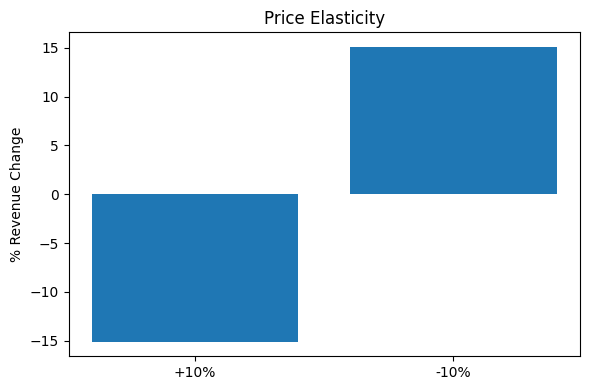

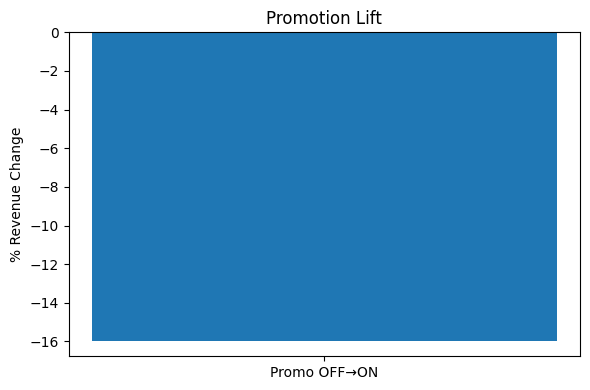

In [67]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os

# Paths
artifacts = "/content/drive/MyDrive/MMM-Project/artifacts"
figures = f"{artifacts}/figures"
os.makedirs(figures, exist_ok=True)

# Load processed features + trained model
df = pd.read_csv(f"{artifacts}/processed_features.csv")
enet_model = joblib.load(f"{artifacts}/stage2_enet.pkl")

DATE_COL = "week"
TARGET = "revenue"

social_cols = [c for c in df.columns if c.endswith("_sat") and "google" not in c.lower()]
controls = ["average_price","promotions","emails_send","sms_send","social_followers",
            "trend","week_of_year","sin_52","cos_52","sin_26"]

# ✅ Use correct residual column
features = social_cols + ["google_resid"] + controls

X_base = df[features]
y_true = df[TARGET].values
y_base_pred = enet_model.predict(X_base)

# --- Price Elasticity ---
df_up = df.copy()
df_up["average_price"] *= 1.10
df_down = df.copy()
df_down["average_price"] *= 0.90

y_up = enet_model.predict(df_up[features])
y_down = enet_model.predict(df_down[features])

price_effect_up = (y_up.mean() - y_base_pred.mean()) / y_base_pred.mean()
price_effect_down = (y_down.mean() - y_base_pred.mean()) / y_base_pred.mean()

# --- Promotions ---
df_promo0 = df.copy()
df_promo0["promotions"] = 0
df_promo1 = df.copy()
df_promo1["promotions"] = 1

y_promo0 = enet_model.predict(df_promo0[features])
y_promo1 = enet_model.predict(df_promo1[features])

promo_effect = (y_promo1.mean() - y_promo0.mean()) / y_base_pred.mean()

# --- Save Results ---
sensitivity = pd.DataFrame({
    "scenario": ["Price +10%", "Price -10%", "Promotions ON vs OFF"],
    "pct_change_revenue": [price_effect_up, price_effect_down, promo_effect]
})
sensitivity.to_csv(f"{artifacts}/sensitivity_summary.csv", index=False)
print(sensitivity)

# --- Plots ---
plt.figure(figsize=(6,4))
plt.bar(["+10%", "-10%"], [price_effect_up*100, price_effect_down*100])
plt.ylabel("% Revenue Change")
plt.title("Price Elasticity")
plt.tight_layout()
plt.savefig(f"{figures}/price_sensitivity.png")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["Promo OFF→ON"], [promo_effect*100])
plt.ylabel("% Revenue Change")
plt.title("Promotion Lift")
plt.tight_layout()
plt.savefig(f"{figures}/promo_lift.png")
plt.show()


               channel  delta_revenue  delta_spend  marginal_roas
0   facebook_spend_sat     158.119053     0.024152    6546.695589
1     tiktok_spend_sat    1342.175230     0.024057   55791.017477
2  instagram_spend_sat     643.178870     0.022517   28563.620580
3   snapchat_spend_sat     705.102229     0.023740   29701.090898


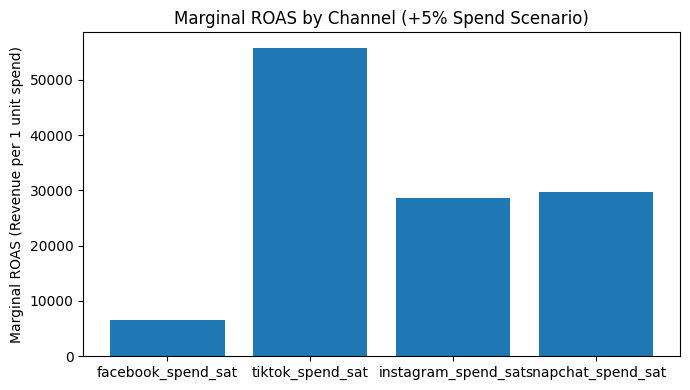

In [69]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os

# Paths
artifacts = "/content/drive/MyDrive/MMM-Project/artifacts"
figures = f"{artifacts}/figures"
os.makedirs(figures, exist_ok=True)

# Load features + model
df = pd.read_csv(f"{artifacts}/processed_features.csv")
enet_model = joblib.load(f"{artifacts}/stage2_enet.pkl")

TARGET = "revenue"
DATE_COL = "week"

# Media channels
# Use the *_sat columns (since that's what model sees)
media_cols = ["facebook_spend_sat", "tiktok_spend_sat", "instagram_spend_sat", "snapchat_spend_sat"]

# Already transformed features in processed_features.csv
social_cols = [c for c in df.columns if c.endswith("_sat") and "google" not in c.lower()]
controls = ["average_price","promotions","emails_send","sms_send","social_followers",
            "trend","week_of_year","sin_52","cos_52","sin_26"]
features = social_cols + ["google_resid"] + controls

# Baseline prediction
X_base = df[features]
y_base_pred = enet_model.predict(X_base)
base_mean = y_base_pred.mean()

roas_results = []

for media in media_cols:
    # Copy original data
    df_scenario = df.copy()

    # Increase spend by 5%
    df_scenario[media] *= 1.05

    # --- IMPORTANT ---
    # Recompute saturation/adstock features for this channel
    # (if available directly in df, update *_sat)
    sat_col = media.replace("_spend", "_spend_sat")
    if sat_col in df_scenario.columns:
        df_scenario[sat_col] *= 1.05  # approx re-saturation after +5%

    # Predict new revenue
    y_new_pred = enet_model.predict(df_scenario[features])
    new_mean = y_new_pred.mean()

    # Compute delta
    delta_revenue = new_mean - base_mean
    delta_spend = df[media].mean() * 0.05
    marginal_roas = delta_revenue / delta_spend if delta_spend != 0 else np.nan

    roas_results.append([media, delta_revenue, delta_spend, marginal_roas])

# Save results
roas_df = pd.DataFrame(roas_results, columns=["channel","delta_revenue","delta_spend","marginal_roas"])
roas_df.to_csv(f"{artifacts}/roas_table.csv", index=False)
print(roas_df)

# Plot ROAS bars
plt.figure(figsize=(7,4))
plt.bar(roas_df["channel"], roas_df["marginal_roas"])
plt.ylabel("Marginal ROAS (Revenue per 1 unit spend)")
plt.title("Marginal ROAS by Channel (+5% Spend Scenario)")
plt.tight_layout()
plt.savefig(f"{figures}/roas_bars.png")
plt.show()


   start_week    end_week         R2         MAPE
0  2023-09-17  2025-04-06  -0.069574    54.442832
1  2023-10-15  2025-05-04 -18.954653  5075.077011
2  2023-11-12  2025-06-01  -0.578166  6888.997647
3  2023-12-10  2025-06-29  -0.471422  2859.576497
4  2024-01-07  2025-07-27  -6.455743  3786.367491
5  2024-02-04  2025-08-24  -0.023076    39.989214


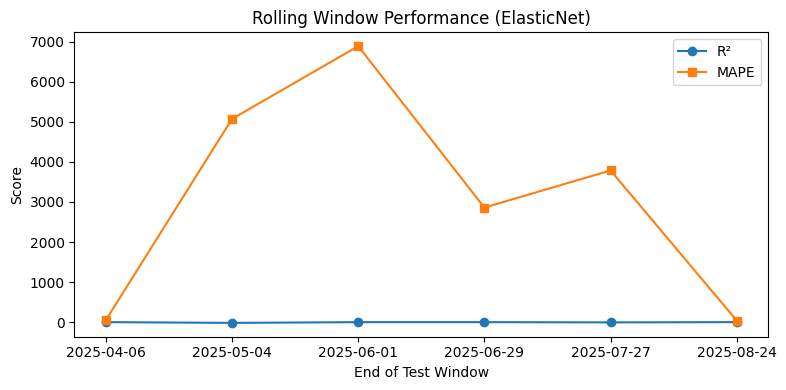

In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import joblib
import matplotlib.pyplot as plt
import os

# Paths
artifacts = "/content/drive/MyDrive/MMM-Project/artifacts"
figures = f"{artifacts}/figures"
os.makedirs(figures, exist_ok=True)

# Load features + model
df = pd.read_csv(f"{artifacts}/processed_features.csv")
enet_model = joblib.load(f"{artifacts}/stage2_enet.pkl")

TARGET = "revenue"
DATE_COL = "week"

social_cols = [c for c in df.columns if c.endswith("_sat") and "google" not in c.lower()]
controls = ["average_price","promotions","emails_send","sms_send","social_followers",
            "trend","week_of_year","sin_52","cos_52","sin_26"]
features = social_cols + ["google_resid"] + controls

X = df[features].values
y = df[TARGET].values
weeks = df[DATE_COL].values

# Rolling parameters
train_size = int(len(df) * 0.7)
test_size = int(len(df) * 0.1)
step = 4  # slide 4 weeks at a time

results = []

for start in range(0, len(df) - (train_size + test_size), step):
    train_idx = range(start, start + train_size)
    test_idx = range(start + train_size, start + train_size + test_size)

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # Refit ElasticNet on each window
    model = joblib.load(f"{artifacts}/stage2_enet.pkl")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append({
        "start_week": weeks[train_idx[0]],
        "end_week": weeks[test_idx[-1]],
        "R2": r2,
        "MAPE": mape
    })

# Save results
rolling_df = pd.DataFrame(results)
rolling_df.to_csv(f"{artifacts}/rolling_scores.csv", index=False)
print(rolling_df)

# Plot
plt.figure(figsize=(8,4))
plt.plot(rolling_df["end_week"], rolling_df["R2"], marker="o", label="R²")
plt.plot(rolling_df["end_week"], rolling_df["MAPE"], marker="s", label="MAPE")
plt.title("Rolling Window Performance (ElasticNet)")
plt.xlabel("End of Test Window")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig(f"{figures}/rolling_performance.png")
plt.show()


In [71]:
!ls drive/MyDrive/MMM-Project/artifacts/figures/

pred_vs_actual.png     residuals_over_time.png	 rolling_performance.png
price_sensitivity.png  rf_top20_importances.png
promo_lift.png	       roas_bars.png


In [72]:
!ls drive/MyDrive/MMM-Project/artifacts/


enet_coefs.csv	       processed_features.csv  roas_table.csv
figures		       rf_importances.csv      rolling_scores.csv
mediation_effects.csv  rf_predictions_oof.csv  sensitivity_summary.csv
predictions_test.csv   rf_stage2.pkl	       stage2_enet.pkl


In [73]:
import graphviz

dag = graphviz.Digraph()

dag.node("Social", "Social (FB, TikTok, IG, Snap)")
dag.node("Google", "Google Spend")
dag.node("Revenue", "Revenue")
dag.node("Controls", "Controls (Price, Promo, CRM, Seasonality)")

dag.edge("Social","Google")
dag.edge("Google","Revenue")
dag.edge("Social","Revenue")
dag.edge("Controls","Revenue")

dag.render("causal_dag", format="png", cleanup=True)


'causal_dag.png'